# Determine Contribution of Metadata to Feature Differences

We perform an analysis of variance (ANOVA) model to determine if metadata information or real biology treatments contribute to observed differences in each cell painting feature.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "signature_utils.R"))

In [2]:
set.seed(123)
datasets = c("four_clone", "cloneAE")

input_data_dir = "data"
output_fig_dir = file.path("figures", "anova")
output_results_dir = file.path("results", "signatures")

## Load Profiles

In [3]:
bulk_col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_plate_ID = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_batch = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_character(),
    Metadata_sample_index = readr::col_character()
)

In [4]:
# Load the bulk dataset built in 0.compile_bulk_dataset
bulk_data <- list()
train_test_status <- list()
for (dataset in datasets) {
    bulk_file <- file.path(
        input_data_dir,
        paste0("bulk_profiles_", dataset, ".csv.gz")
    )

    bulk_df <- readr::read_csv(bulk_file, col_types=bulk_col_types) %>%
        dplyr::filter(Metadata_treatment == "0.1% DMSO")

    # Split into training and testing sets
    test_df <- bulk_df %>%
        dplyr::group_by(Metadata_Plate, Metadata_clone_number) %>% 
        dplyr::sample_frac(size = 0.15)

    # Break out training and testing splits
    test_samples_df <- test_df %>%
        dplyr::select(dplyr::starts_with("Metadata_")) %>%
        dplyr::mutate(Metadata_signature_train_test = "test")
    
    train_df <- bulk_df %>%
        dplyr::filter(!Metadata_sample_index %in% test_samples_df$Metadata_sample_index)
    
    train_samples_df <- train_df %>% dplyr::select(dplyr::starts_with("Metadata_")) %>%
        dplyr::mutate(Metadata_signature_train_test = "train")

    sample_signature_train_test_status <- test_samples_df %>%
        dplyr::bind_rows(train_samples_df) %>%
        dplyr::mutate(Metadata_dataset = dataset)

    # Select only DMSO treated wells
    bulk_data[[dataset]] <- train_df
    train_test_status[[dataset]] <- sample_signature_train_test_status
}

In [5]:
# For plotting and assessment
output_file <- file.path(output_results_dir, "train_test_status.csv")
status_df <- do.call(rbind, train_test_status) %>% readr::write_csv(output_file)

In [6]:
lm_results <- list()
tukey_results <- list()
anova_figures <- list()
tukey_figures <- list()
signatures <- list()
for (dataset in datasets) {
    bulk_df <- bulk_data[[dataset]]
    
    # Setup the ANOVA terms
    if (dataset == "four_clone") {
        # The cloneAE dataset only has WT_parental lines
        bulk_df <- bulk_df %>% dplyr::filter(Metadata_clone_number != "WT_parental")
        formula_terms <- paste(
            "~",
            "Metadata_clone_type_indicator", "+",
            "Metadata_batch", "+",
            "Metadata_Plate", "+",
            "Metadata_clone_number"
        )
    } else {
        formula_terms <- paste(
            "~",
            "Metadata_clone_type_indicator", "+",
            "Metadata_Plate", "+",
            "Metadata_clone_number"
        )
    }
    bulk_data[[dataset]] <- bulk_df
    
    print(dataset)
    print(dim(bulk_df))
    
    # Fit linear model to determine sources of variation and process results
    lm_results[[dataset]] <- perform_anova(bulk_df, formula_terms)
    
    full_results_df <- lm_results[[dataset]][["full_results_df"]] %>%
        dplyr::arrange(desc(neg_log_p))
    
    features <- unique(full_results_df$feature)

    # Perform TukeyHSD
    full_tukey_results_df <- process_tukey(
        aov_list = lm_results[[dataset]][["aovs"]],
        features = features
    )
    tukey_results[[dataset]] <- full_tukey_results_df
    
    num_cp_features <- length(features)

    # Note that TukeyHSD() p value is already adjusted for multiple within comparisons,
    # but not across multiple features
    signif_line <- -log10(0.05 / num_cp_features)
    
    fig_title <- paste0(
        "Comparing Wildtype and Resistant clones (",
        dataset,
        ")\nANOVA effects for all ",
        num_cp_features,
        " CP features"
    )
    
    # Plot ANOVA distribution results
    difference_contribution_gg <- ggplot(full_results_df, aes(x = neg_log_p)) +
        geom_density(aes(fill = term), alpha = 0.4) +
        theme_bw() +
        xlab("-log10 p value") +
        ylab("") +
        ggtitle(fig_title) +
        theme(axis.text = element_text(size = 6),
              axis.title = element_text(size = 7),
              title = element_text(size = 8))

    out_file <- file.path(
        output_fig_dir,
        paste0("bulk_anova_effect_term_distributions_", dataset, ".png")
        )
    ggsave(out_file, dpi = 500, height = 5, width = 4)
    anova_figures[[dataset]] <- difference_contribution_gg
    
    # Plot feature distributions
    tukey_volcano_gg <- ggplot(full_tukey_results_df, aes(x = estimate, y = neg_log_adj_p)) +
        geom_point(aes(color = comparison)) +
        geom_hline(yintercept = signif_line, color = "red", linetype = "dashed") +
        facet_wrap("~term", nrow=length(unique(full_tukey_results_df$term))) +
        theme_bw() +
        xlab("Statistic") +
        ylab("-log10 P Value") +
        ggtitle(fig_title) +
        theme(
            strip.text = element_text(size = 8, color = "black"),
            strip.background = element_rect(colour = "black", fill = "#fdfff4"),
            legend.position="none"
        )

    out_file <- file.path(output_fig_dir, paste0("bulk_tukey_volcano_", dataset, ".png"))
    ggsave(out_file, dpi = 500, height = 5, width = 4)

    tukey_figures[[dataset]] <- tukey_volcano_gg
    
    # Derive signature by systematically removing features influenced by technical differences
    signature_features <- full_tukey_results_df %>%
        dplyr::filter(term == "Metadata_clone_type_indicator", neg_log_adj_p > !!signif_line) %>%
        dplyr::pull(feature)

    feature_exclude_plate <- full_tukey_results_df %>%
        dplyr::filter(term == "Metadata_Plate", neg_log_adj_p > !!signif_line) %>%
        dplyr::pull(feature)
    
    if (dataset == "four_clone") {
        feature_exclude_batch <- full_tukey_results_df %>%
            dplyr::filter(term == "Metadata_batch", neg_log_adj_p > !!signif_line) %>%
            dplyr::pull(feature)
        
        signature_features <- setdiff(signature_features, feature_exclude_batch)
    }
        
    signature_features <- setdiff(signature_features, feature_exclude_plate)
    signature_features <- sort(signature_features)
    
    # Compile signature output
    bulk_signature_df <- full_results_df %>%
        dplyr::filter(feature %in% signature_features, term == "Metadata_clone_type_indicator")

    bulk_tukey_signature_df <- full_tukey_results_df %>%
        dplyr::filter(feature %in% signature_features, term == "Metadata_clone_type_indicator")
    colnames(bulk_tukey_signature_df) <- paste0(colnames(bulk_tukey_signature_df), "_tukey")

    bulk_signature_df <- bulk_signature_df %>%
        dplyr::left_join(
            bulk_tukey_signature_df,
            by = c("term" = "term_tukey", "feature" = "feature_tukey"),
            suffix = c("", "_tukey")
        )
    
    signatures[[dataset]] <- bulk_signature_df

    output_file <- file.path(output_results_dir, paste0("bulk_signature_", dataset, ".tsv"))
    bulk_signature_df %>% readr::write_tsv(output_file)
}

[1] "four_clone"
[1] 168 338
[1] "cloneAE"
[1]  48 338


Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

$four_clone

$cloneAE


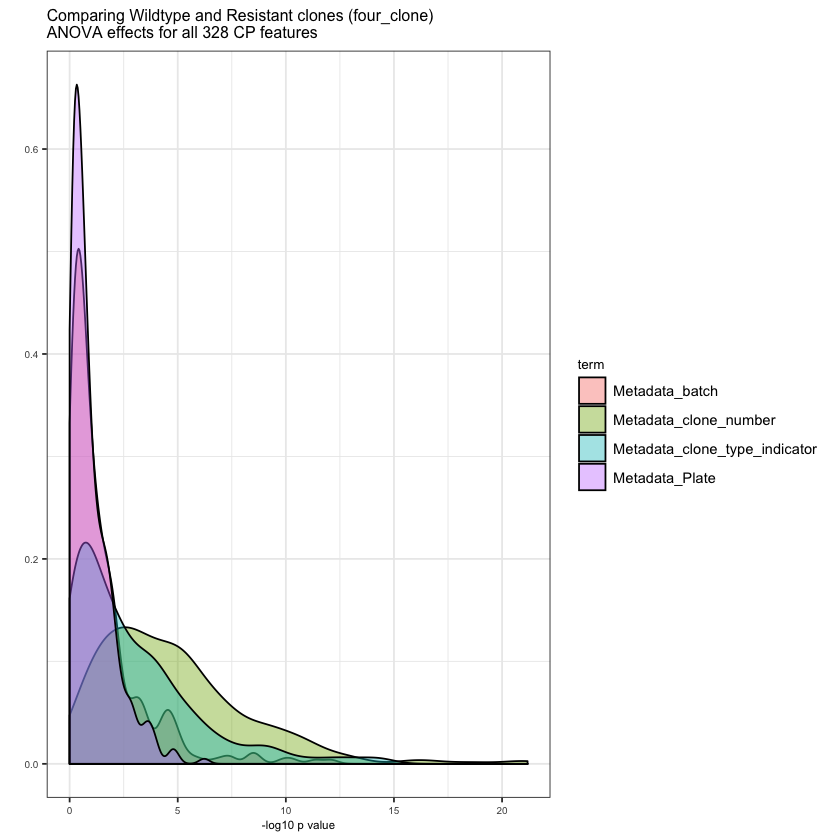

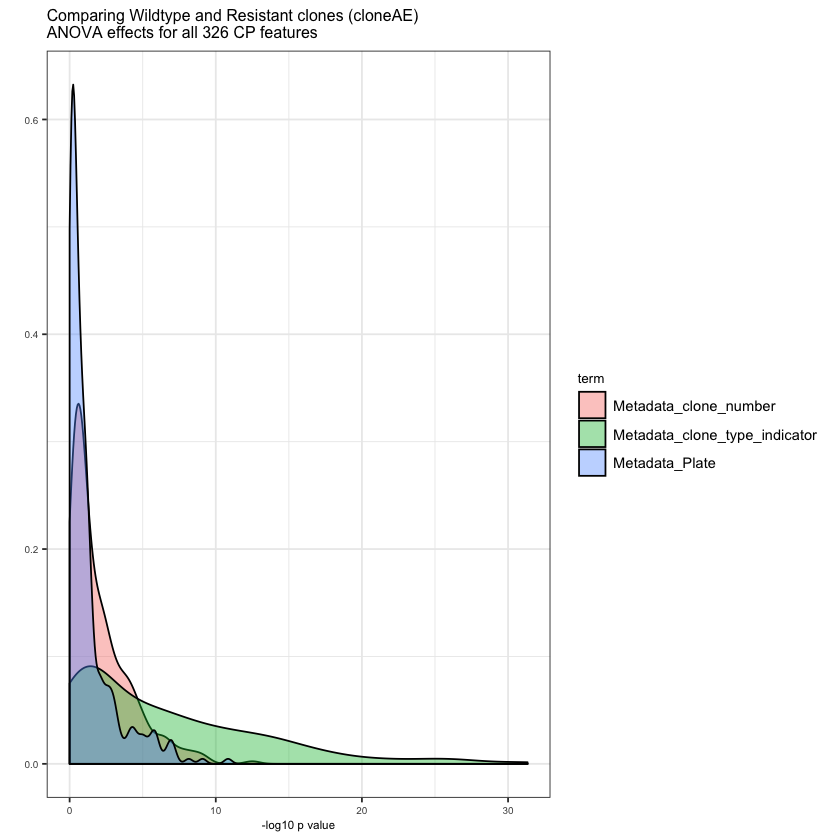

In [7]:
anova_figures

$four_clone

$cloneAE


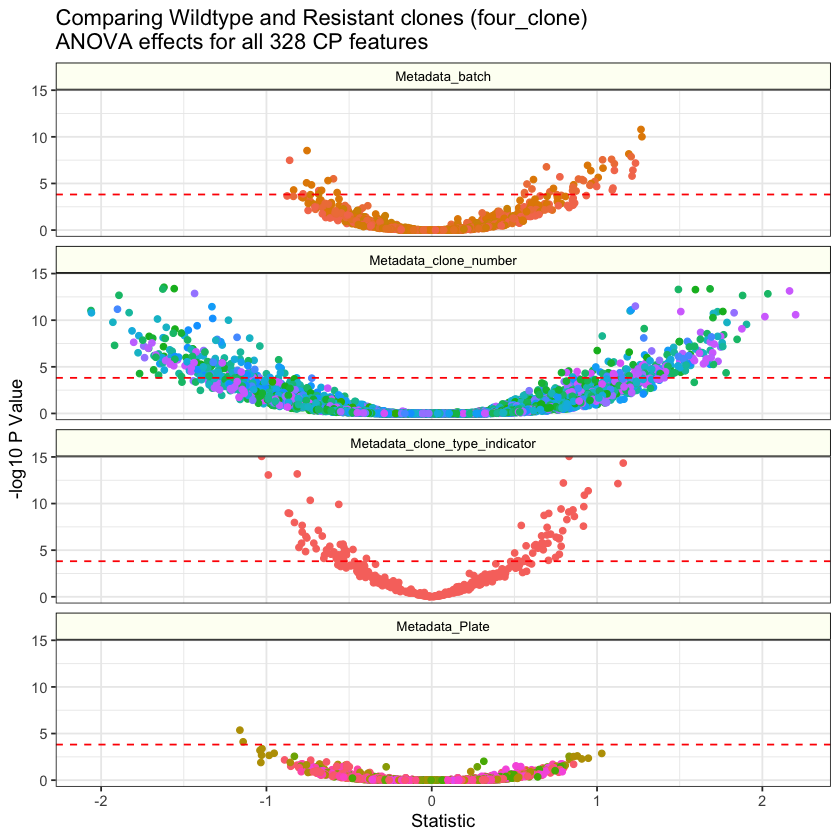

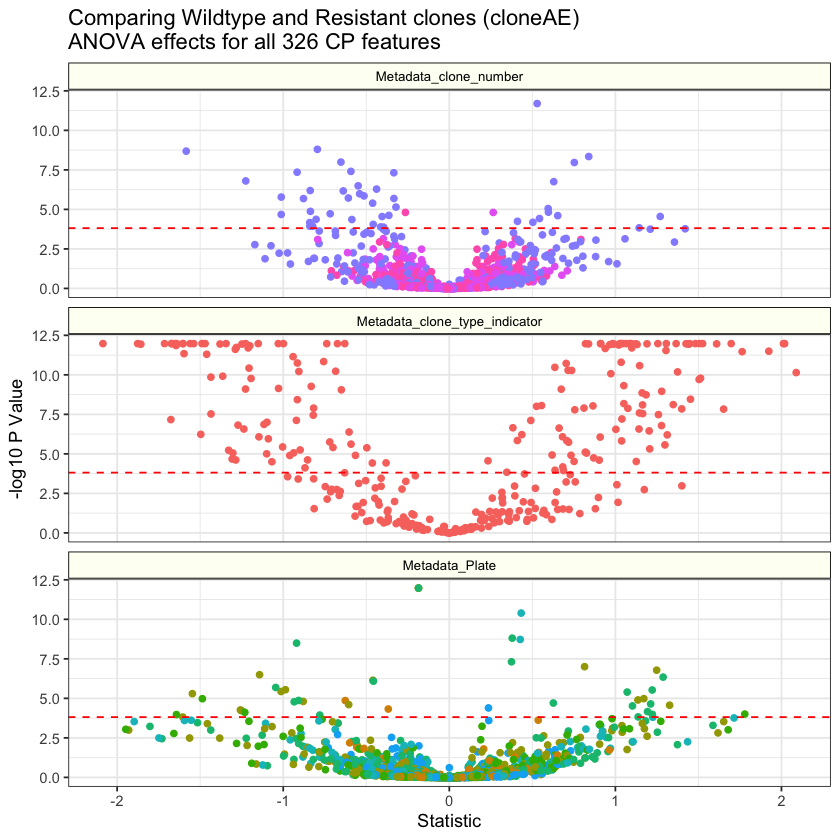

In [8]:
tukey_figures